# Projeto final Visualização da Informação - Análise Exploratória

O objetivo desse projeto é explorar dados eleitorais do sudeste do país, mais especificamente das eleições presidenciais de 2018. O ano escolhido a princípio havia sido 2022, pois é um tema bem recente e de interesse, mas ao utilizar os dados do TSE (através da Base dos Dados, como farei ao longo do trabalho) tive problemas com dados faltantes e muito inconsistentes. Portanto, o projeto está sendo desenvolvido para 2018, mas tenho forte intenção de revisitá-lo mais adiante para explorar possibilidades com o ano de 2022.

Queremos, ao final da análise, ter gráficos prontos para utilização em uma peça final de visualização, que terá o formato de um infográfico, então as análises aqui presentes serão posteriormente "limpas", isto é, removerei legendas, eixos e tudo que será composto posteriormente na peça final.

Iniciarei realizando as importações necessárias:

In [26]:
# importaçoes
import pandas as pd
import altair as alt
import json
import geopandas as gpd
import basedosdados as bd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns

Carregaremos nossos dados através do uso da Base dos Dados, conforme mencionado:

In [27]:
# carregar dados eleitorais (tse)
detalhes_votacao_municipio = bd.read_table(dataset_id='br_tse_eleicoes',
                    table_id='detalhes_votacao_municipio',
                    billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 320628/320628 [01:53<00:00, 2828.85rows/s]


In [28]:
# carregar dados geográficos (ipea)
municipio_geometry = bd.read_table(dataset_id='br_geobr_mapas',
                table_id='municipio',
                billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 5567/5567 [07:16<00:00, 12.75rows/s]


Iniciamos o processo de tratamento dos dados, buscando apenas aqueles que nos interessam e convertendo os dados espaciais para o formato adequado para plotagem:

In [29]:
# pegar linhas desejadas (ano 2018, cargo presidente, uf valida)
election_2018 = detalhes_votacao_municipio.query("cargo == 'presidente' & ano == 2018 & sigla_uf != 'ZZ'",)
election_2018['proporcao_abstencao'] = 100 - election_2018['proporcao_comparecimento']


In [30]:
# filtra o sudeste, junta dados eleitorais e geográficos
municipio_geometry_sudeste = municipio_geometry.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG']")
municipio_geometry_sudeste = pd.merge(municipio_geometry_sudeste, election_2018, on='id_municipio', how = 'inner')
municipio_geometry_sudeste['geometria'] = municipio_geometry_sudeste['geometria'].apply(wkt.loads)
municipio_geometry_sudeste_gpd = gpd.GeoDataFrame(municipio_geometry_sudeste, geometry='geometria')
municipio_geometry_sudeste_gpd['proporcao_brancos_nulos'] = municipio_geometry_sudeste_gpd['proporcao_votos_brancos'] + municipio_geometry_sudeste_gpd['proporcao_votos_nulos']



In [31]:
municipio_geometry_sudeste_gpd.head()

,id_municipio,sigla_uf_x,geometria,ano,turno,tipo_eleicao,sigla_uf_y,id_municipio_tse,cargo,aptos,...,votos_validos,votos_brancos,votos_nulos,votos_legenda,proporcao_comparecimento,proporcao_votos_validos,proporcao_votos_brancos,proporcao_votos_nulos,proporcao_abstencao,proporcao_brancos_nulos
0,3100104,MG,"MULTIPOLYGON (((-47.48345 -18.18071, -47.47999...",2018,1,eleicao ordinaria,MG,40010,presidente,5772,...,4128,118,370,0,79.972282,89.428078,2.556326,8.015598,20.027718,10.571924
1,3100104,MG,"MULTIPOLYGON (((-47.48345 -18.18071, -47.47999...",2018,2,eleicao ordinaria,MG,40010,presidente,5772,...,3938,83,527,0,78.794182,86.587509,1.824978,11.587511,21.205818,13.412489
2,3100203,MG,"MULTIPOLYGON (((-45.24166 -18.91319, -45.23498...",2018,1,eleicao ordinaria,MG,40037,presidente,18605,...,12542,452,838,0,74.345604,90.673798,3.267785,6.058415,25.654396,9.326200
3,3100203,MG,"MULTIPOLYGON (((-45.24166 -18.91319, -45.23498...",2018,2,eleicao ordinaria,MG,40037,presidente,18605,...,11870,375,1390,0,73.286751,87.055374,2.750275,10.194353,26.713249,12.944628
4,3100302,MG,"MULTIPOLYGON (((-42.49664 -20.19489, -42.49455...",2018,1,eleicao ordinaria,MG,40053,presidente,10626,...,7680,214,543,0,79.399590,91.027618,2.536447,6.435937,20.600410,8.972383


A princípio os dados já podem ser utilizados para desenvolver gráficos espaciais, como desejava, então realizamos um teste plotando o sudeste sem informações:

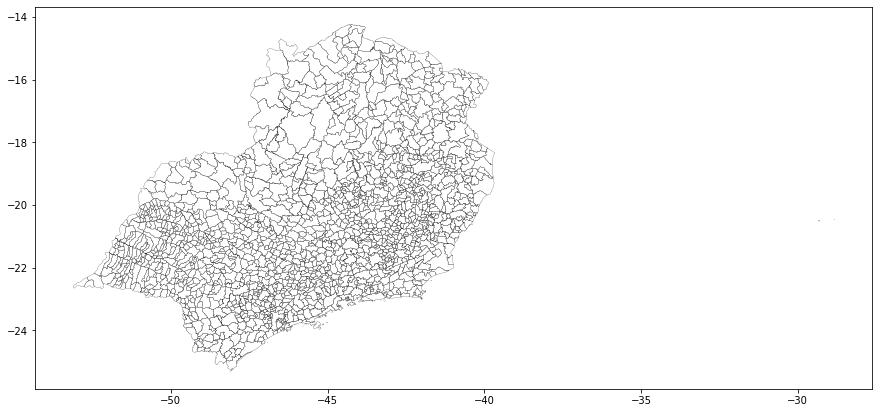

In [32]:
# testando geometrias
ax = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (15, 15), edgecolor = 'black', linewidth = 0.1)

Deixamos preparados, também, filtros por turno de eleições, que serão usados mais adiante:

In [33]:
# filtros turno
flt1 = ((municipio_geometry_sudeste_gpd['turno'] == 1))
flt2 = ((municipio_geometry_sudeste_gpd['turno'] == 2))


## Análise brancos e nulos

A princípio realizaremos análises quanto à presença de votos brancos e nulos no sudeste. Note 

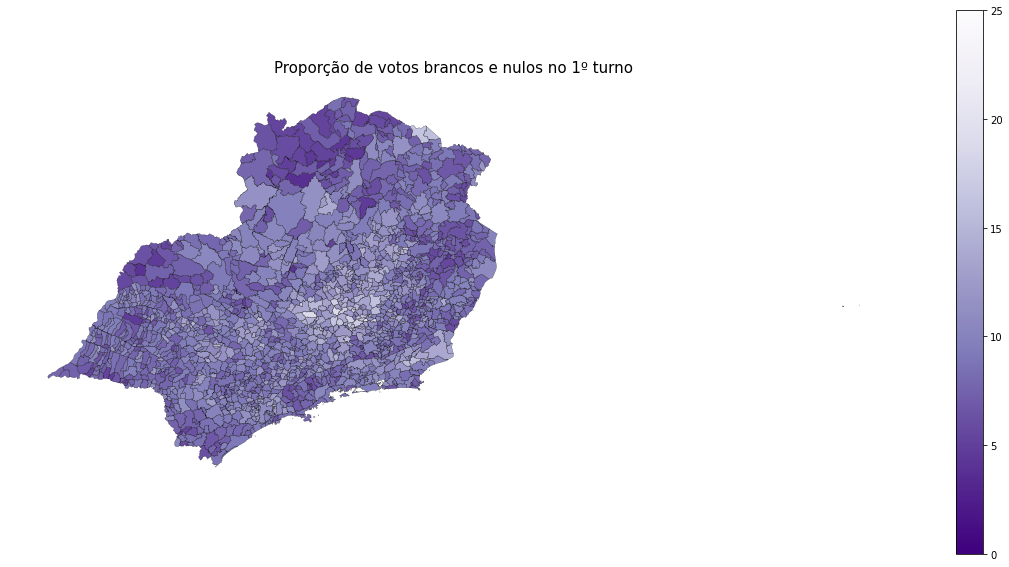

In [34]:
# proporcao brancos e nulos 1º turno

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt1].plot(column = 'proporcao_brancos_nulos',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples_r',
                                        vmin = 0,
                                        vmax = 25
                                        )
ax.set_axis_off()
# set title
ax.set_title('Proporção de votos brancos e nulos no 1º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})

plt.show()

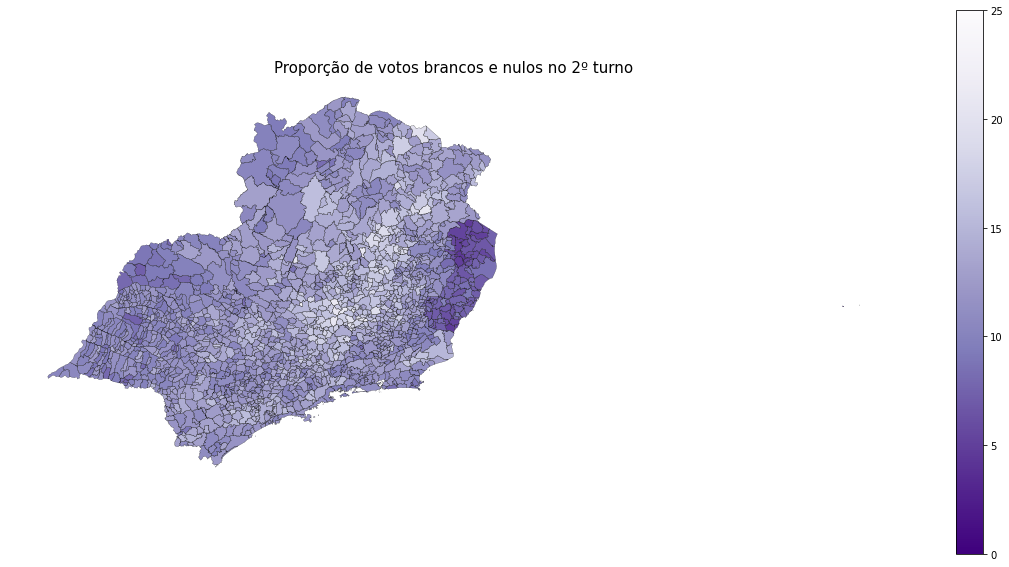

In [35]:
# proporcao brancos e nulos 2º turno

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt2].plot(column = 'proporcao_brancos_nulos',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples_r',
                                        vmin = 0,
                                        vmax = 25
                                        )

ax.set_axis_off()

# set legend
leg = ax.get_legend()



# set title
ax.set_title('Proporção de votos brancos e nulos no 2º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})
plt.show()


## Análise a respeito de abstenções

Realizei também esta plotagem (com relação a abstenções), mas posteriormente, ao pensar melhor em como organizar o infográfico, decidi manter os anteriores na peça e representar essa informação como gráficos de barra, dispostos mais adiante. Mantive aqui os gráficos espaciais produzidos:

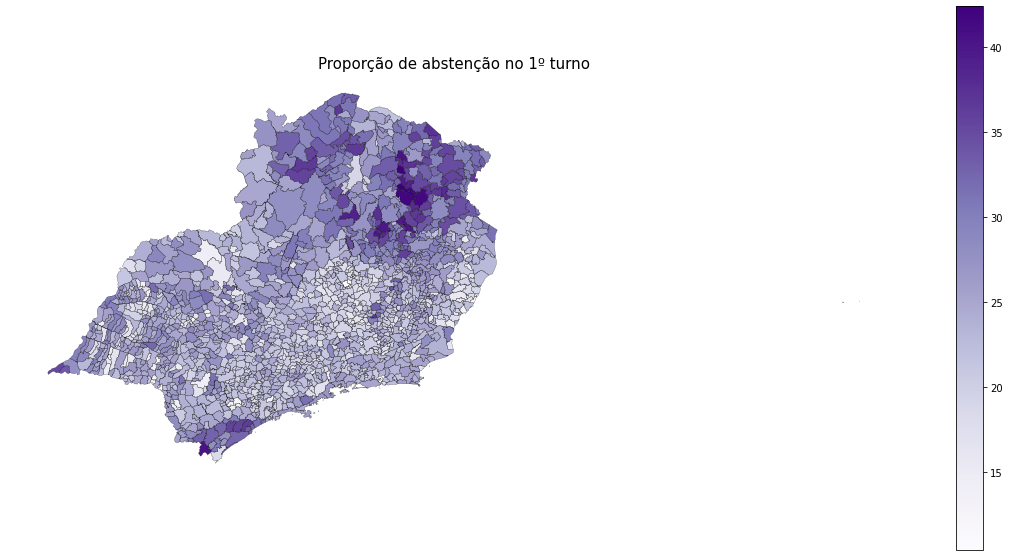

In [36]:
# proporçao abstencao 1º turno

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt1].plot(column = 'proporcao_abstencao',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples'
                                        )
ax.set_axis_off()

# set title
ax.set_title('Proporção de abstenção no 1º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})

plt.show()

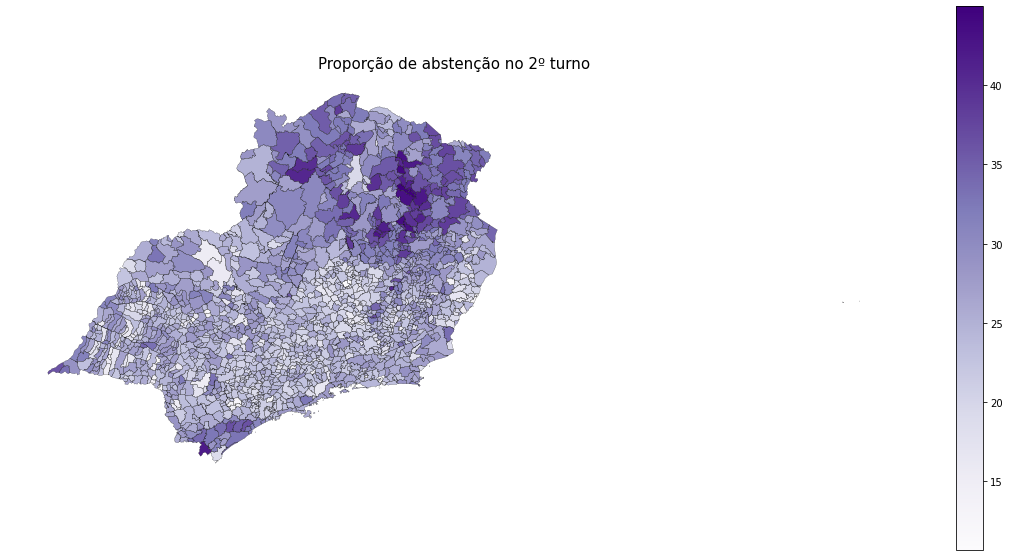

In [37]:
# proporçao abstencao 2º turno

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt2].plot(column = 'proporcao_abstencao',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples'
                                        )
ax.set_axis_off()

# set title
ax.set_title('Proporção de abstenção no 2º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})

plt.show()

A princípio havia um plano de utilizar 2 gráficos de barra, um para cada turno, alinhados ao gráfico de mapa correspondente. No entanto, a diferença sutil entre os turnos não ficou suficientemente clara ao "empilhar" os gráficos, então preferi utilizar um úncio de barras duplas. Mantive, também, os gráficos individuais aqui:

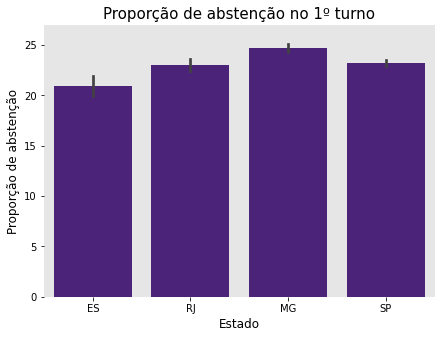

In [38]:
# proporcao abstencoes 1º turno

election_2018_1 = election_2018.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG'] & turno == 1")

# do the same with purple color
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.set_ylim(0, 27)
ax.set_facecolor('#E6E6E6')
sns.barplot(x = 'sigla_uf', y = 'proporcao_abstencao', data = election_2018_1, ax = ax, color = '#4A1587')
sns.despine(left=True, bottom=True)

# set title
ax.set_title('Proporção de abstenção no 1º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})

# set labels
ax.set_xlabel('Estado', fontdict={'fontsize': '12', 'fontweight' : '3'})
ax.set_ylabel('Proporção de abstenção', fontdict={'fontsize': '12', 'fontweight' : '3'})

plt.show()

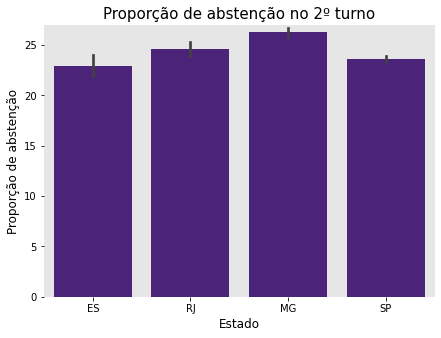

In [39]:
# proporcao abstencoes 2º turno

election_2018_2 = election_2018.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG'] & turno == 2")

fig, ax = plt.subplots(1, figsize=(7, 5))
ax.set_ylim(0, 27)
ax.set_facecolor('#E6E6E6')
sns.barplot(x = 'sigla_uf', y = 'proporcao_abstencao', data = election_2018_2, ax = ax, color = '#4A1587')
sns.despine(left=True, bottom=True)

# set title
ax.set_title('Proporção de abstenção no 2º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})

# set labels
ax.set_xlabel('Estado', fontdict={'fontsize': '12', 'fontweight' : '3'})
ax.set_ylabel('Proporção de abstenção', fontdict={'fontsize': '12', 'fontweight' : '3'})

plt.show()

Por fim, desenvolvi o gráfico que preferi utilizar no infográfico, que está a seguir. Observe que, posteriormente, a maior parte dos metadados foi removido e inserido posteriormente na peça final de forma a favorecer a organização da peça.

In [40]:
# make horizontal barplot of abstencao by state of 1st and 2nd turn

election_2018_3 = election_2018.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG']")

fig, ax = plt.subplots(1, figsize=(5, 7))
ax.set_ylim(0, 27)
ax.set_facecolor('#E6E6E6')
sns.barplot(x = 'proporcao_abstencao', y = 'sigla_uf', data = election_2018_3, ax = ax, hue = 'turno', palette = ['#FFFFFF', '#B39DDB'], order = ['ES', 'RJ', 'SP', 'MG'])
sns.despine(left=True, bottom=True)

# set title
ax.set_title('Proporção de abstenção por estado', fontdict={'fontsize': '13', 'fontweight' : '3'})

# set axis labels
ax.set_xlabel('Proporção de abstenção (%)')
ax.set_ylabel('Estado')

plt.show()

SyntaxError: invalid syntax (106600180.py, line 4)

## Análise Espiríto Santo resultado

Na peça final há um destaque a esse estado devido ao resultado observado no gráfico de brancos e nulos no segundo turno. Por isso, realizei algumas análises de resultados nesse estado, e foi necessário receber outra tabela da Base dos Dados:

In [ ]:
# obtencao de resultados por municipio no 1º turno

query = """
SELECT *
FROM basedosdados.br_tse_eleicoes.resultados_candidato_municipio
WHERE ano in (2018) AND sigla_uf in ('ES') AND cargo in ('presidente') AND turno in (1)
"""

resultados_candidato_municipio_main = bd.read_sql(query, 
                                billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 1014/1014 [00:00<00:00, 2602.19rows/s]


In [ ]:
resultados_candidato_municipio = resultados_candidato_municipio_main

Também para diagramação da peça final, decidi fazer um gráfico setorial (havia muitas barras e linhas verticais, pelo próprio gráfico de barras, escala de cores do gráfico espacial, fonte de texto...). O "movimento" me parecia necessário para completar a peça e eu estava decidida a fazer 2 ou 3 setores apenas:

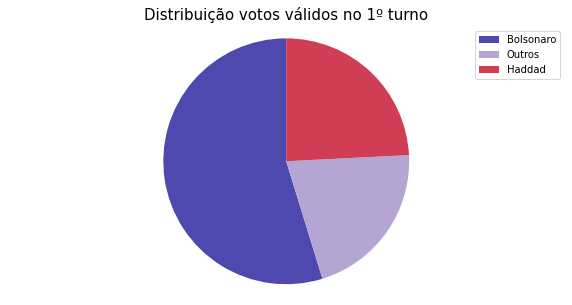

In [ ]:
# do pie chart of votes by candidate at 1st turn

# make all numero_candidato not in ['13', '17'] to 'outros'
resultados_candidato_municipio.loc[~resultados_candidato_municipio['numero_candidato'].isin(['13', '17']), 'numero_candidato'] = '14'

# group by numero_candidate and sum votos
resultados_candidato_municipio = resultados_candidato_municipio.groupby(['numero_candidato']).sum().reset_index()
resultados_candidato_municipio = resultados_candidato_municipio.sort_values(by=['numero_candidato'], ascending=False)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.pie(resultados_candidato_municipio['votos'], startangle=90,  colors = ['#4E49AF','#B5A5D3','#D13D55'])
ax.axis('equal')

# set title
ax.set_title('Distribuição votos válidos no 1º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})

# show legend
plt.legend(labels = ['Bolsonaro', 'Outros', 'Haddad'], loc = 'upper right')

plt.show()

In [ ]:
# dados de votos por municipio no 2º turno

query = """
SELECT *
FROM basedosdados.br_tse_eleicoes.resultados_candidato_municipio
WHERE ano in (2018) AND sigla_uf in ('ES') AND cargo in ('presidente') AND turno in (2)
"""

resultados_candidato_municipio_main2 = bd.read_sql(query, 
                                billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 156/156 [00:00<00:00, 495.09rows/s]


In [ ]:
resultados_candidato_municipio = resultados_candidato_municipio_main2

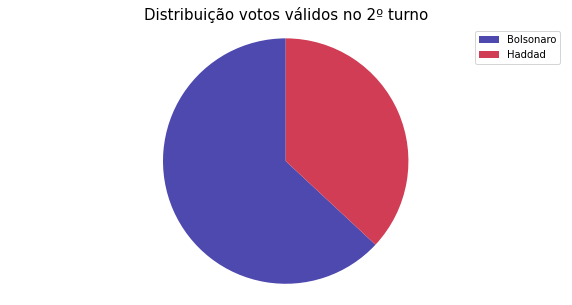

In [ ]:
# do pie chart of votes by candidate at 1st turn

# make all numero_candidato not in ['13', '17'] to 'outros'
resultados_candidato_municipio.loc[~resultados_candidato_municipio['numero_candidato'].isin(['13', '17']), 'numero_candidato'] = '14'

# group by numero_candidate and sum votos
resultados_candidato_municipio = resultados_candidato_municipio.groupby(['numero_candidato']).sum().reset_index()
resultados_candidato_municipio = resultados_candidato_municipio.sort_values(by=['votos'], ascending=False)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.pie(resultados_candidato_municipio['votos'], startangle=90, colors=['#4E49AF','#D13D55'])
ax.axis('equal')

# set title
ax.set_title('Distribuição votos válidos no 2º turno', fontdict={'fontsize': '15', 'fontweight' : '3'})

# show legend
plt.legend(labels = ['Bolsonaro', 'Haddad'], loc = 'upper right')

plt.show()

Por fim, realizei a plotagem do mapa do Espírito Santo para composição de detalhes na peça.

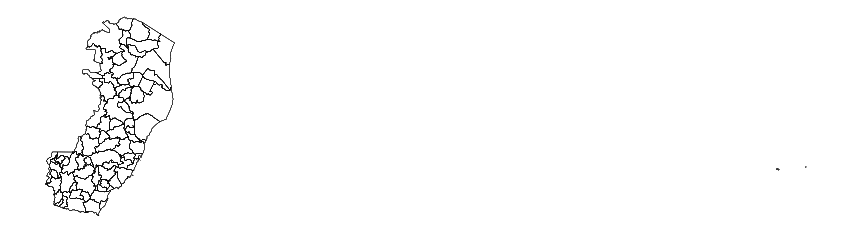

In [ ]:
municipio_geometry_es = municipio_geometry.query("sigla_uf in ['ES']")
municipio_geometry_es = pd.merge(municipio_geometry_es, resultados_candidato_municipio_main, on='id_municipio', how = 'inner')
municipio_geometry_es['geometria'] = municipio_geometry_es['geometria'].apply(wkt.loads)
municipio_geometry_es_gpd = gpd.GeoDataFrame(municipio_geometry_es, geometry='geometria')
ax = municipio_geometry_es_gpd.boundary.plot(figsize = (15, 20), edgecolor = 'black', linewidth = 0.1)
ax.set_axis_off()

